In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

class LombAnalysis:
    """
    A class to perform Lomb-Scargle periodogram analysis on a time series,
    optionally using linear-parameter fitting and residual computation.

    Typical Workflow:
      1. Instantiate with time (t), values (x), and a set of candidate frequencies.
      2. (Optional) compute_linear_params(...) + compute_residuals(...) to get the residual series.
      3. run_lomb() or compute_lomb_periodogram() to get the Lomb-Scargle powers.
      4. filter_results(...) to discard frequencies deemed invalid.
      5. show_spectrum(...) to visualize the final power spectrum and highlight results.
    """

    def __init__(self,
                 t: np.ndarray,
                 x: np.ndarray,
                 freqs: np.ndarray,
                 significance_level: float = 0.95):
        """
        Initialize the LombAnalysis with time-series data and candidate frequencies.

        Parameters
        ----------
        t : np.ndarray
            1D array of time points, shape (N,).
        x : np.ndarray
            1D array of observed values (e.g., residuals), shape (N,).
        freqs : np.ndarray
            1D array of candidate frequencies for which to compute the Lomb-Scargle power.
        significance_level : float, optional
            Statistical significance level p in [0,1], default=0.95.

        Raises
        ------
        ValueError
            If t and x have different lengths, or freqs is empty.
        """
        if t.shape[0] != x.shape[0]:
            raise ValueError("Time array (t) and data array (x) must be the same length.")
        if len(freqs) == 0:
            raise ValueError("The frequency array cannot be empty.")

        self.t = t
        self.x = x
        self.freqs = freqs
        self.significance_level = significance_level

        self.power = None  # Will hold the Lomb-Scargle power array
        self.critical_value = None  # Will store the significance threshold
        self.filtered_freqs = None  # After filtering
        self.filtered_power = None

    @staticmethod
    def compute_linear_params(t: np.ndarray,
                              y: np.ndarray,
                              t_c: float,
                              alpha: float,
                              omega: float,
                              phi: float) -> tuple[float, float, float]:
        """
        Compute linear parameters (A, B, C) for a simplified LPPL model:

            y(t) ~ A + B*(t_c - t)^alpha + C*(t_c - t)^alpha*cos(omega ln(t_c - t) + phi)

        using linear regression on a sub-interval.

        Parameters
        ----------
        t : np.ndarray
            1D array of time points, shape (N,).
        y : np.ndarray
            1D array of observed data, shape (N,).
        t_c : float
        alpha : float
        omega : float
        phi : float

        Returns
        -------
        (A, B, C) : tuple of floats
            Solved from the normal equations (V^T V)(A,B,C)^T = (V^T y).
        """
        dt = t_c - t
        f = dt ** alpha
        g = f * np.cos(omega * np.log(dt) + phi)

        # Build design matrix
        V = np.column_stack((np.ones_like(f), f, g))
        # Solve [A, B, C] via linear algebra
        params = np.linalg.inv(V.T @ V) @ (V.T @ y)
        A, B, C = params
        return A, B, C

    @staticmethod
    def compute_residuals(t: np.ndarray,
                          y: np.ndarray,
                          A: float,
                          B: float,
                          t_c: float,
                          alpha: float,
                          C: float = 0.0,
                          omega: float = 0.0,
                          phi: float = 0.0,
                          include_oscillation: bool = False) -> np.ndarray:
        """
        Compute the residuals after subtracting a fitted LPPL-like model:
            y(t) = A + B*(t_c - t)^alpha + [C*(t_c - t)^alpha*cos(omega*ln(t_c - t) + phi)] if needed.

        Parameters
        ----------
        t : np.ndarray, shape (N,)
            Time points.
        y : np.ndarray, shape (N,)
            Observed data.
        A, B : float
            Linear parameters for the simplified or partial LPPL model.
        t_c, alpha : float
            Nonlinear LPPL parameters.
        C : float, optional
            Amplitude parameter for the oscillatory part.
        omega : float, optional
            Frequency parameter for the oscillatory part.
        phi : float, optional
            Phase parameter for the oscillatory part.
        include_oscillation : bool, optional
            If True, subtract both the trend and the oscillatory part.
            If False, subtract only A + B*(t_c - t)^alpha.

        Returns
        -------
        np.ndarray, shape (N,)
            Residual = y - model(t).
        """
        dt = t_c - t
        trend = A + B * (dt ** alpha)

        if include_oscillation:
            osc = C * (dt ** alpha) * np.cos(omega * np.log(dt) + phi)
            model = trend + osc
        else:
            model = trend

        return y - model
    
    def compute_lomb_periodogram(self, use_package: bool = False) -> tuple[np.ndarray, np.ndarray]:
        """
        Perform Lomb periodogram analysis for the given time series x at times t with a set of frequencies.

        Parameters:
        - t: Time points (array)
        - x: Observed values (array)
        - freqs: Frequency series to test (array)
        - p: Statistical significance level (default 0.95)

        Returns:
        - P: Power spectral density for each frequency in freqs
        - valid_freq: The frequency with the highest valid power
        """

        if use_package:
            ls = LombScargle(self.t, self.x)
            self.power = ls.power(self.freqs)

        else:
            J = len(self.t)
            mean_x = 1/J * np.sum(self.x)  # mean of x
            var_x = 1/(J-1) * np.sum((self.x - mean_x) **2) # variance of x
            self.power = []

            # Compute the Lomb periodogram for each frequency
            for f in self.freqs:
                # Calculate time offset t
                sin_term = np.sum(np.sin(4 * np.pi * f * self.t))
                cos_term = np.sum(np.cos(4 * np.pi * f * self.t))
                t_offset = (1 / (4 * np.pi * f)) * np.arctan(sin_term / cos_term)

                # Calculate power spectral density P(f)
                cos_num = np.sum((self.x - mean_x) * np.cos(2 * np.pi * f * (self.t - t_offset))) ** 2
                cos_denom = np.sum(np.cos(2 * np.pi * f * (self.t - t_offset)) ** 2)
                sin_num = np.sum((self.x - mean_x) * np.sin(2 * np.pi * f * (self.t - t_offset))) ** 2
                sin_denom = np.sum(np.sin(2 * np.pi * f * (self.t - t_offset)) ** 2)
                power_value = (cos_num/cos_denom + sin_num/sin_denom) / (2 * var_x)
                self.power.append(power_value)

            # Convert to array for convenience
            self.power = np.array(self.power)

        # compute significance threshold for convenience
        M = len(self.freqs)
        # critical_value = -ln(1 - (1 - p)^(1/M))
        self.critical_value = -np.log(1.0 - (1.0 - self.significance_level) ** (1.0 / M))

        return self.freqs, self.power


    def filter_results(self,
                       remove_mpf: bool = True,
                       mpf_threshold: float = 1e-3,
                       mpf_factor: float = 1.5
                       ) -> tuple[np.ndarray, np.ndarray]:
        """
        Filter out invalid frequencies from the computed Lomb-Scargle power.
        1) Remove f_mpf ~ mpf_factor / J
        2) Remove power < self.critical_value

        Parameters
        ----------
        remove_mpf : bool, optional
            If True, remove the "most probable frequency" ~ mpf_factor / N, by default True.
        mpf_factor : float, optional
            The factor to compute f_mpf = mpf_factor / N, by default 1.5

        Returns
        -------
        (filtered_freqs, filtered_power): (np.ndarray, np.ndarray)
            The frequency-power pairs that remain after filtering.
        """
        if self.power is None:
            raise RuntimeError("You must run compute_lomb_periodogram() before filtering results.")

        N = len(self.x)
        mpf = mpf_factor / N

        freqs_in = self.freqs
        power_in = self.power
        f_out = []
        p_out = []

        for (f, pwr) in zip(freqs_in, power_in):
            # 1) skip if near f_mpf
            if remove_mpf and abs(f - mpf) < mpf_threshold:
                continue
            # 2) skip if below significance threshold
            if pwr < self.critical_value:
                continue
            f_out.append(f)
            p_out.append(pwr)

        self.filtered_freqs = np.array(f_out)
        self.filtered_power = np.array(p_out)

        return self.filtered_freqs, self.filtered_power
    
    def check_significance(self, target_freq: float) -> bool:
        """
        Check if the target frequency is statistically significant.

        Parameters
        ----------
        target_freq : float
            The frequency to check.

        Returns
        -------
        bool
            True if the target frequency is significant, False otherwise.
        """
        if self.power is None:
            raise RuntimeError("No Lomb-Scargle power computed. Call compute_lomb_periodogram() first.")

        if self.critical_value is None:
            raise RuntimeError("No significance threshold computed. Call compute_lomb_periodogram() first.")

        if self.filtered_freqs is None or self.filtered_power is None:
            raise RuntimeError("No filtered results found. Call filter_results() first.")


        idx = np.argmax(self.filtered_power)

        # Check if idx is within 5% of the target frequency
        return abs(self.filtered_freqs[idx] - target_freq) < 0.05

    def show_spectrum(self,
                      use_filtered: bool = False,
                      show_threshold: bool = False,
                      show_max_power: bool = False,
                      highlight_freq: float | None = None) -> None:
        """
        Plot the Lomb-Scargle power spectrum.

        Parameters
        ----------
        use_filtered : bool, optional
            If True, plot the filtered frequencies/power. Otherwise, plot the raw spectrum.
        show_threshold : bool, optional
            If True, draw a horizontal line at the critical_value.
        highlight_freq : float or None, optional
            If provided, draw a vertical line at this frequency to highlight a target freq.

        Returns
        -------
        None
            Displays a matplotlib figure.
        """
        if self.power is None:
            raise RuntimeError("No Lomb-Scargle power computed. Call compute_lomb_periodogram() first.")

        if use_filtered and (self.filtered_freqs is None or self.filtered_power is None):
            raise RuntimeError("No filtered results found. Call filter_results() first.")

        if use_filtered:
            freqs_plot = self.filtered_freqs
            power_plot = self.filtered_power
            title = "Lomb-Scargle (Filtered)"
        else:
            freqs_plot = self.freqs
            power_plot = self.power
            title = "Lomb-Scargle (All Frequencies)"

        plt.figure(figsize=(8, 4))
        plt.plot(freqs_plot, power_plot, label="Lomb-Scargle Power", color="blue")
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.title(title)
  

        if show_threshold and self.critical_value is not None:
            plt.axhline(y=self.critical_value, color="red", linestyle="--",
                        label=f"Significance threshold={self.critical_value:.2f}")

        if highlight_freq is not None:
            plt.axvline(x=highlight_freq, color="green", linestyle=":", 
                        label=f"Highlighted freq={highlight_freq:.4f}")
            # Add a gray vertical line 5% away from the target freq
            plt.axvline(x=highlight_freq + 0.05, color="gray", linestyle=":")
            plt.axvline(x=highlight_freq - 0.05, color="gray", linestyle=":")

        if show_max_power:
            idx_peak = np.argmax(power_plot)
            best_freq = freqs_plot[idx_peak]
            best_power = power_plot[idx_peak]
            plt.axvline(x=best_freq, color="orange", linestyle="--", label="Max Power")
            

        plt.legend()
        plt.yscale('log')  # Apply log scale to the y-axis
        plt.tight_layout()
        plt.show()

    def run(self, use_filtered: bool = True, use_package: bool = False) -> None:
        """
        Convenience method to:
          1. Compute the Lomb-Scargle power at each frequency.
          2. Filter results with default settings.
          3. Plot the final filtered spectrum.
        """
        self.compute_lomb_periodogram(use_package=use_package)
        self.filter_results()
        self.show_spectrum(use_filtered=use_filtered)

In [8]:
from Utilities import load_data, select_sample
from MPGA import MPGA
import json

def lppl(t, A, B, tc, alpha, C, omega, phi):
    return A + B * np.abs(tc - t) ** alpha + C * np.abs(tc - t) ** alpha * np.cos(omega * np.log(np.abs(tc - t)) + phi)


# Exemple d'utilisation
file_path = 'WTI_Spot_Price_daily.csv'
data = load_data(file_path)

df = data.copy()

with open("results-2011_2015_1.json", "r") as f:
    results = json.load(f)

validated_solutions = []

t = np.linspace(0, len(data) - 1, len(data))

global_dates = data[:, 0]

data = np.insert(data, 0, t, axis=1)

data = data[:, [0, 2]].astype(float)

global_time = data[:, 0]
global_price = data[:, 1]

import numpy as np
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt

for i in range(len(results['subintervals'])):

    t_start = results['subintervals'][i]['sub_start']
    t_end = results['subintervals'][i]['sub_end']
    rss_val = results['subintervals'][i]['bestObjV']
    params = results['subintervals'][i]['bestChrom']
    tc, omega, phi, alpha = params

    freqs = np.linspace(0.0, 1.0, 1000)

    mask = (global_time >= t_start) & (global_time <= t_end)
    t_sub = global_time[mask]
    y_sub = global_price[mask]


    A, B, C = LombAnalysis.compute_linear_params(t_sub, y_sub, tc, alpha, omega, phi)
    x_sub = LombAnalysis.compute_residuals(t_sub, y_sub, A, B, tc, alpha)
    

    Lomb = LombAnalysis(t=t_sub, x=x_sub, freqs=freqs)
    Lomb.compute_lomb_periodogram(use_package=False)
    Lomb.filter_results(mpf_threshold=0.001)
    #Lomb.show_spectrum(use_filtered=False, highlight_freq=omega/(2*np.pi), show_threshold=True, show_max_power=True)
    if Lomb.check_significance(omega/(2*np.pi)):
        validated_solutions.append(params)
        print(f"Subinterval {i+1} is significant.")

    extended_t_sub = np.arange(t_sub[0], round(tc) + 1000)
    extended_y_sub = global_price[int(extended_t_sub[0]):int(extended_t_sub[-1] + 1)]
    extended_dates_sub = global_dates[int(extended_t_sub[0]):int(extended_t_sub[-1] + 1)]

    y_pred = lppl(extended_t_sub, A, B, tc, alpha, C, omega, phi)

    end_date = global_dates[int(t_sub[-1])]

    # plt.figure(figsize=(10, 6))
    # plt.plot(extended_dates_sub, extended_y_sub, label='Observed')
    # plt.plot(extended_dates_sub, y_pred, label='Predicted')
    # plt.axvline(x=end_date, color='r', linestyle='--', label='End of Subinterval')
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    # plt.title(f'Subinterval {i+1}: LPPL Model Prediction')
    # plt.legend()
    # plt.show()

    

/var/folders/vk/z0p4r5z97d99dp7mpbt9yd1w0000gn/T/ipykernel_24358/772058750.py:179: RuntimeWarning: divide by zero encountered in scalar divide
  t_offset = (1 / (4 * np.pi * f)) * np.arctan(sin_term / cos_term)
/var/folders/vk/z0p4r5z97d99dp7mpbt9yd1w0000gn/T/ipykernel_24358/772058750.py:179: RuntimeWarning: invalid value encountered in scalar multiply
  t_offset = (1 / (4 * np.pi * f)) * np.arctan(sin_term / cos_term)


Subinterval 1 is significant.
Subinterval 2 is significant.
Subinterval 3 is significant.
Subinterval 4 is significant.
Subinterval 5 is significant.
Subinterval 6 is significant.
Subinterval 9 is significant.
Subinterval 10 is significant.
Subinterval 11 is significant.
Subinterval 16 is significant.
Subinterval 17 is significant.
Subinterval 18 is significant.
Subinterval 21 is significant.
Subinterval 23 is significant.
Subinterval 24 is significant.
Subinterval 25 is significant.
Subinterval 26 is significant.
Subinterval 27 is significant.
Subinterval 32 is significant.
Subinterval 33 is significant.
Subinterval 34 is significant.
Subinterval 35 is significant.
Subinterval 36 is significant.
Subinterval 39 is significant.
Subinterval 46 is significant.
Subinterval 47 is significant.
Subinterval 48 is significant.
Subinterval 49 is significant.
Subinterval 50 is significant.
Subinterval 53 is significant.
Subinterval 54 is significant.
Subinterval 61 is significant.
Subinterval 63 

23


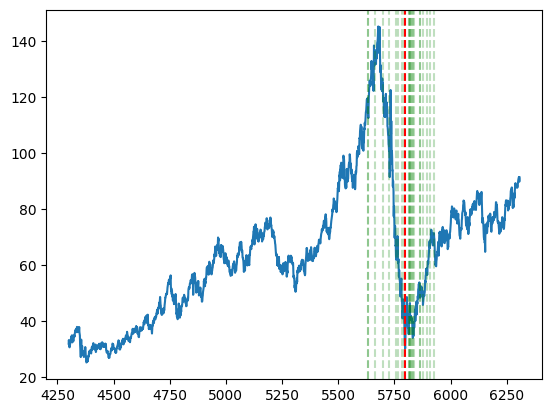

In [ ]:

print(len(validated_solutions))

# with open("validated_solutions_2003-2008.json", "w") as f:
#     json.dump(validated_solutions, f)


import pandas as pd
import matplotlib.pyplot as plt

t_c_list = []

for i in range(len(validated_solutions)):
    t_c = validated_solutions[i][0]
    t_c_list.append(int(round(t_c)))

# Exemple d'utilisation
file_path = 'WTI_Spot_Price_daily.csv'
data = load_data(file_path)


df = pd.DataFrame(data, columns=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])

t_c_list = [x for x in t_c_list if x <= len(df)]
t_c_date_list = df.iloc[t_c_list]['Date'].unique()


# Définir les dates de début et de fin
start_date = '2003-01-01'
end_date = '2010-12-31'

# Filtrer le DataFrame entre les dates de début et de fin
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
filtered_df = df.loc[mask]


filtered_df['Price'].plot()
for t_c in t_c_list:
    # plot une ligne verticale pour chaque t_c
    plt.axvline(x=t_c, color='g', linestyle='--', alpha=0.25)

# # rajoute en verre time_start et time_end
# time_start = df[df['Date'] == time_start].index[0]
# time_end = df[df['Date'] == time_end].index[0]

# plt.axvline(x=time_start, color='g', linestyle='--')
plt.axvline(x=np.mean(t_c_list), color='green', linestyle='--')

plt.show()





3


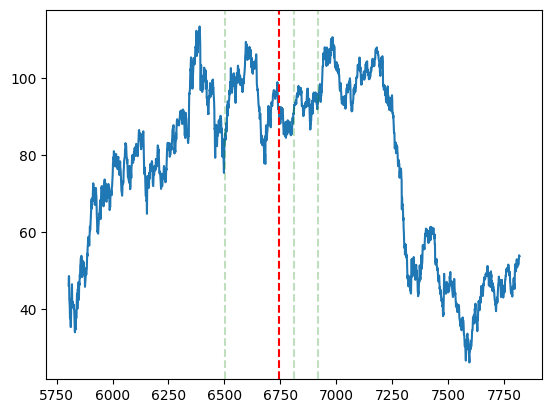

In [3]:

print(len(validated_solutions))

# with open("validated_solutions_2003-2008.json", "w") as f:
#     json.dump(validated_solutions, f)


import pandas as pd
import matplotlib.pyplot as plt

t_c_list = []

for i in range(len(validated_solutions)):
    t_c = validated_solutions[i][0]
    t_c_list.append(int(round(t_c)))

# Exemple d'utilisation
file_path = 'WTI_Spot_Price_daily.csv'
data = load_data(file_path)


df = pd.DataFrame(data, columns=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])

t_c_list = [x for x in t_c_list if x <= len(df)]
t_c_date_list = df.iloc[t_c_list]['Date'].unique()


# Définir les dates de début et de fin
start_date = '2009-01-01'
end_date = '2016-12-31'

# Filtrer le DataFrame entre les dates de début et de fin
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
filtered_df = df.loc[mask]


filtered_df['Price'].plot()
for t_c in t_c_list:
    # plot une ligne verticale pour chaque t_c
    plt.axvline(x=t_c, color='g', linestyle='--', alpha=0.25)

# # rajoute en verre time_start et time_end
# time_start = df[df['Date'] == time_start].index[0]
# time_end = df[df['Date'] == time_end].index[0]

# plt.axvline(x=time_start, color='g', linestyle='--')
plt.axvline(x=np.mean(t_c_list), color='red', linestyle='--')

plt.show()





47


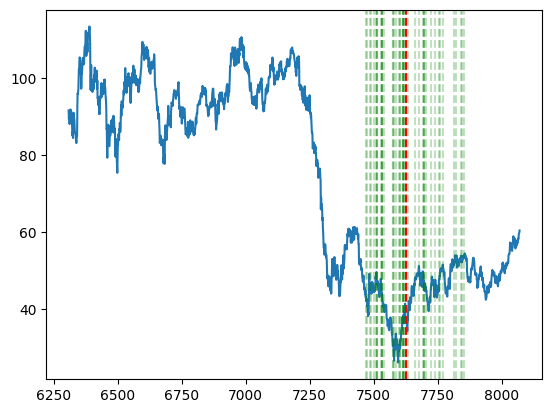

In [80]:

print(len(validated_solutions))

# with open("validated_solutions_2003-2008.json", "w") as f:
#     json.dump(validated_solutions, f)


import pandas as pd
import matplotlib.pyplot as plt

t_c_list = []

for i in range(len(validated_solutions)):
    t_c = validated_solutions[i][0]
    t_c_list.append(int(round(t_c)))

# Exemple d'utilisation
file_path = 'WTI_Spot_Price_daily.csv'
data = load_data(file_path)


df = pd.DataFrame(data, columns=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])

t_c_list = [x for x in t_c_list if x <= len(df)]
t_c_date_list = df.iloc[t_c_list]['Date'].unique()


# Définir les dates de début et de fin
start_date = '2011-01-01'
end_date = '2017-12-31'

# Filtrer le DataFrame entre les dates de début et de fin
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
filtered_df = df.loc[mask]


filtered_df['Price'].plot()
for t_c in t_c_list:
    # plot une ligne verticale pour chaque t_c
    plt.axvline(x=t_c, color='g', linestyle='--', alpha=0.25)

# # rajoute en verre time_start et time_end
# time_start = df[df['Date'] == time_start].index[0]
# time_end = df[df['Date'] == time_end].index[0]

# plt.axvline(x=time_start, color='g', linestyle='--')
plt.axvline(x=np.mean(t_c_list), color='red', linestyle='--')

plt.show()





43


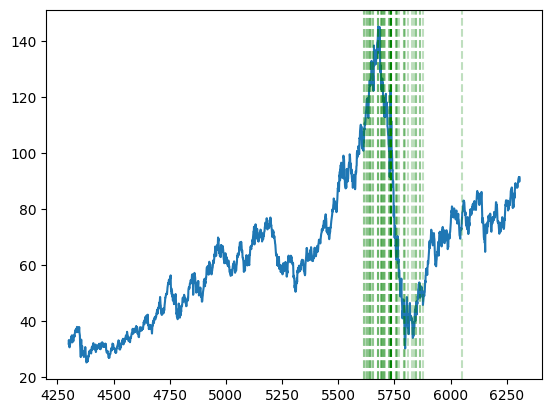

In [5]:

print(len(validated_solutions))

# with open("validated_solutions_2003-2008.json", "w") as f:
#     json.dump(validated_solutions, f)


import pandas as pd
import matplotlib.pyplot as plt

t_c_list = []

for i in range(len(validated_solutions)):
    t_c = validated_solutions[i][0]
    t_c_list.append(int(round(t_c)))

# Exemple d'utilisation
file_path = 'WTI_Spot_Price_daily.csv'
data = load_data(file_path)


df = pd.DataFrame(data, columns=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])

t_c_list = [x for x in t_c_list if x <= len(df)]
t_c_date_list = df.iloc[t_c_list]['Date'].unique()


# Définir les dates de début et de fin
start_date = '2003-01-01'
end_date = '2010-12-31'

# Filtrer le DataFrame entre les dates de début et de fin
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
filtered_df = df.loc[mask]


filtered_df['Price'].plot()
for t_c in t_c_list:
    # plot une ligne verticale pour chaque t_c
    plt.axvline(x=t_c, color='g', linestyle='--', alpha=0.25)

# # rajoute en verre time_start et time_end
# time_start = df[df['Date'] == time_start].index[0]
# time_end = df[df['Date'] == time_end].index[0]

# plt.axvline(x=time_start, color='g', linestyle='--')
plt.axvline(x=np.mean(t_c_list), color='green', linestyle='--')

plt.show()





4


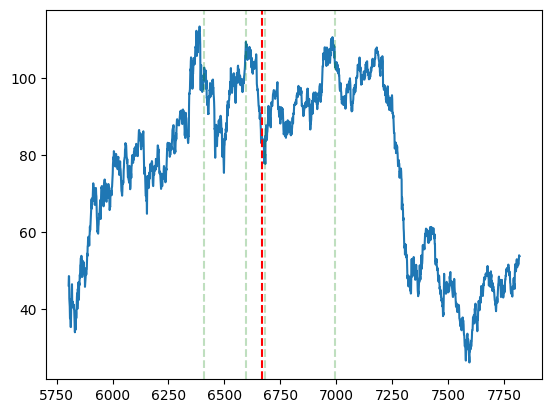

In [7]:

print(len(validated_solutions))

# with open("validated_solutions_2003-2008.json", "w") as f:
#     json.dump(validated_solutions, f)


import pandas as pd
import matplotlib.pyplot as plt

t_c_list = []

for i in range(len(validated_solutions)):
    t_c = validated_solutions[i][0]
    t_c_list.append(int(round(t_c)))

# Exemple d'utilisation
file_path = 'WTI_Spot_Price_daily.csv'
data = load_data(file_path)


df = pd.DataFrame(data, columns=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])

t_c_list = [x for x in t_c_list if x <= len(df)]
t_c_date_list = df.iloc[t_c_list]['Date'].unique()


# Définir les dates de début et de fin
start_date = '2009-01-01'
end_date = '2016-12-31'

# Filtrer le DataFrame entre les dates de début et de fin
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
filtered_df = df.loc[mask]


filtered_df['Price'].plot()
for t_c in t_c_list:
    # plot une ligne verticale pour chaque t_c
    plt.axvline(x=t_c, color='g', linestyle='--', alpha=0.25)

# # rajoute en verre time_start et time_end
# time_start = df[df['Date'] == time_start].index[0]
# time_end = df[df['Date'] == time_end].index[0]

# plt.axvline(x=time_start, color='g', linestyle='--')
plt.axvline(x=np.mean(t_c_list), color='red', linestyle='--')

plt.show()





49


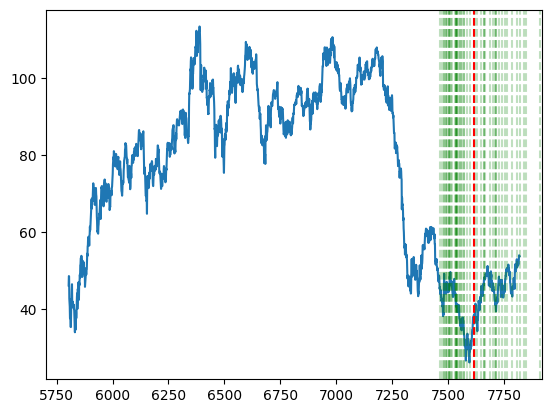

In [9]:

print(len(validated_solutions))

# with open("validated_solutions_2003-2008.json", "w") as f:
#     json.dump(validated_solutions, f)


import pandas as pd
import matplotlib.pyplot as plt

t_c_list = []

for i in range(len(validated_solutions)):
    t_c = validated_solutions[i][0]
    t_c_list.append(int(round(t_c)))

# Exemple d'utilisation
file_path = 'WTI_Spot_Price_daily.csv'
data = load_data(file_path)


df = pd.DataFrame(data, columns=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])

t_c_list = [x for x in t_c_list if x <= len(df)]
t_c_date_list = df.iloc[t_c_list]['Date'].unique()


# Définir les dates de début et de fin
start_date = '2009-01-01'
end_date = '2016-12-31'

# Filtrer le DataFrame entre les dates de début et de fin
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
filtered_df = df.loc[mask]


filtered_df['Price'].plot()
for t_c in t_c_list:
    # plot une ligne verticale pour chaque t_c
    plt.axvline(x=t_c, color='g', linestyle='--', alpha=0.25)

# # rajoute en verre time_start et time_end
# time_start = df[df['Date'] == time_start].index[0]
# time_end = df[df['Date'] == time_end].index[0]

# plt.axvline(x=time_start, color='g', linestyle='--')
plt.axvline(x=np.mean(t_c_list), color='red', linestyle='--')

plt.show()





In [31]:
df

,Date,Price
0,1970-01-01 00:00:00.000000000,25.56
1,1970-01-01 00:00:00.000000001,26.00
2,1970-01-01 00:00:00.000000002,26.53
3,1970-01-01 00:00:00.000000003,25.85
4,1970-01-01 00:00:00.000000004,25.87
...,...,...
9801,1970-01-01 00:00:00.000009801,70.15
9802,1970-01-01 00:00:00.000009802,68.81
9803,1970-01-01 00:00:00.000009803,68.58
9804,1970-01-01 00:00:00.000009804,68.58


In [44]:



# Définir les dates de début et de fin
start_date = '2003-01-01'
end_date = '2010-12-31'

# Filtrer le DataFrame entre les dates de début et de fin
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
filtered_df = df.loc[mask]

print(filtered_df)

           Date  Price
4300 2003-01-02  31.97
4301 2003-01-03  33.26
4302 2003-01-06  32.29
4303 2003-01-07   31.2
4304 2003-01-08  30.66
...         ...    ...
6303 2010-12-27  90.99
6304 2010-12-28  91.48
6305 2010-12-29  91.13
6306 2010-12-30  89.85
6307 2010-12-31  91.38

[2008 rows x 2 columns]


In [34]:
df

,Date,Price
0,1970-01-01 00:00:00.000000000,25.56
1,1970-01-01 00:00:00.000000001,26.00
2,1970-01-01 00:00:00.000000002,26.53
3,1970-01-01 00:00:00.000000003,25.85
4,1970-01-01 00:00:00.000000004,25.87
...,...,...
9801,1970-01-01 00:00:00.000009801,70.15
9802,1970-01-01 00:00:00.000009802,68.81
9803,1970-01-01 00:00:00.000009803,68.58
9804,1970-01-01 00:00:00.000009804,68.58
